In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

sns.set(style="whitegrid", context="talk")

In [4]:
# Load and Inspect dataset
df = pd.read_csv(r"C:\Users\LENOVO\OneDrive\Desktop\online_retail_10k.csv")
print(">>> SHAPE:", df.shape)
print("\n>>> HEAD:")
display(df.head())
print("\n>>> INFO:")
print(df.info())
print("\n>>> NUMERIC SUMMARY:")
display(df.describe(include="all"))

# Missing / Null overview
nulls = df.isnull().sum().sort_values(ascending=False)
print("\n>>> MISSING VALUES (count):\n", nulls[nulls > 0])

>>> SHAPE: (10000, 9)

>>> HEAD:


,transaction_id,customer_id,transaction_date,channel,payment_method,product_category,quantity,unit_price,transaction_amount
0,T0006639,C01099,2019-01-12,Web,Credit Card,Electronics,1,2745.78,2745.78
1,T0007578,C01250,2019-01-13,Web,NaN,Home & Kitchen,1,2057.62,2057.62
2,T0001393,C00230,2019-01-16,Web,Debit Card,Sports,5,184.47,922.36
3,T0009046,C01499,2019-01-16,Web,Credit Card,Books,5,215.97,1079.84
4,T0009039,C01498,2019-01-21,Web,Credit Card,Clothing,1,2476.74,2476.74



>>> INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      10000 non-null  object 
 1   customer_id         10000 non-null  object 
 2   transaction_date    10000 non-null  object 
 3   channel             9799 non-null   object 
 4   payment_method      9799 non-null   object 
 5   product_category    10000 non-null  object 
 6   quantity            10000 non-null  int64  
 7   unit_price          10000 non-null  float64
 8   transaction_amount  10000 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 703.3+ KB
None

>>> NUMERIC SUMMARY:


,transaction_id,customer_id,transaction_date,channel,payment_method,product_category,quantity,unit_price,transaction_amount
count,10000,10000,10000,9799,9799,10000,10000.00000,10000.000000,10000.000000
unique,10000,1600,2218,3,4,7,NaN,NaN,NaN
top,T0006639,C00023,2025-08-29,Web,Credit Card,Electronics,NaN,NaN,NaN
freq,1,19,3173,4880,3975,1510,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.78430,1327.564080,1796.055570
std,NaN,NaN,NaN,NaN,NaN,NaN,1.19177,1110.439975,1158.706116
min,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,34.560000,87.310000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,604.447500,1073.305000
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,1077.635000,1601.910000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2.00000,1789.107500,2308.740000



>>> MISSING VALUES (count):
 channel           201
payment_method    201
dtype: int64


In [5]:
# Cleaning dataset

# Convert date
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")
df = df[df["transaction_date"].notna()].copy()

# Numeric conversions
for col in ["quantity", "unit_price", "transaction_amount"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Validate transaction_amount = quantity * unit_price
df["calc_amount"] = df["quantity"] * df["unit_price"]
mismatch = (df["transaction_amount"].round(2) != df["calc_amount"].round(2)).sum()
if mismatch > 0:
    print(f">>> {mismatch} rows with mismatched transaction_amount replaced by calc_amount")
    df["transaction_amount"] = df["calc_amount"]

df.drop(columns=["calc_amount"], inplace=True)

# Handle negatives (returns/cancellations)
neg_count = (df["transaction_amount"] < 0).sum()
if neg_count > 0:
    print(f">>> {neg_count} negative transaction_amounts set to NaN")
    df.loc[df["transaction_amount"] < 0, "transaction_amount"] = np.nan

# Winsorize outliers
def winsorize(series, p_low=0.01, p_high=0.99):
    lo, hi = series.quantile(p_low), series.quantile(p_high)
    return series.clip(lower=lo, upper=hi)

for col in ["transaction_amount", "quantity", "unit_price"]:
    df[col] = winsorize(df[col])
    df[col] = df[col].fillna(df[col].median())

print("\n>>> After cleaning shape:", df.shape)

>>> 2598 rows with mismatched transaction_amount replaced by calc_amount

>>> After cleaning shape: (10000, 9)


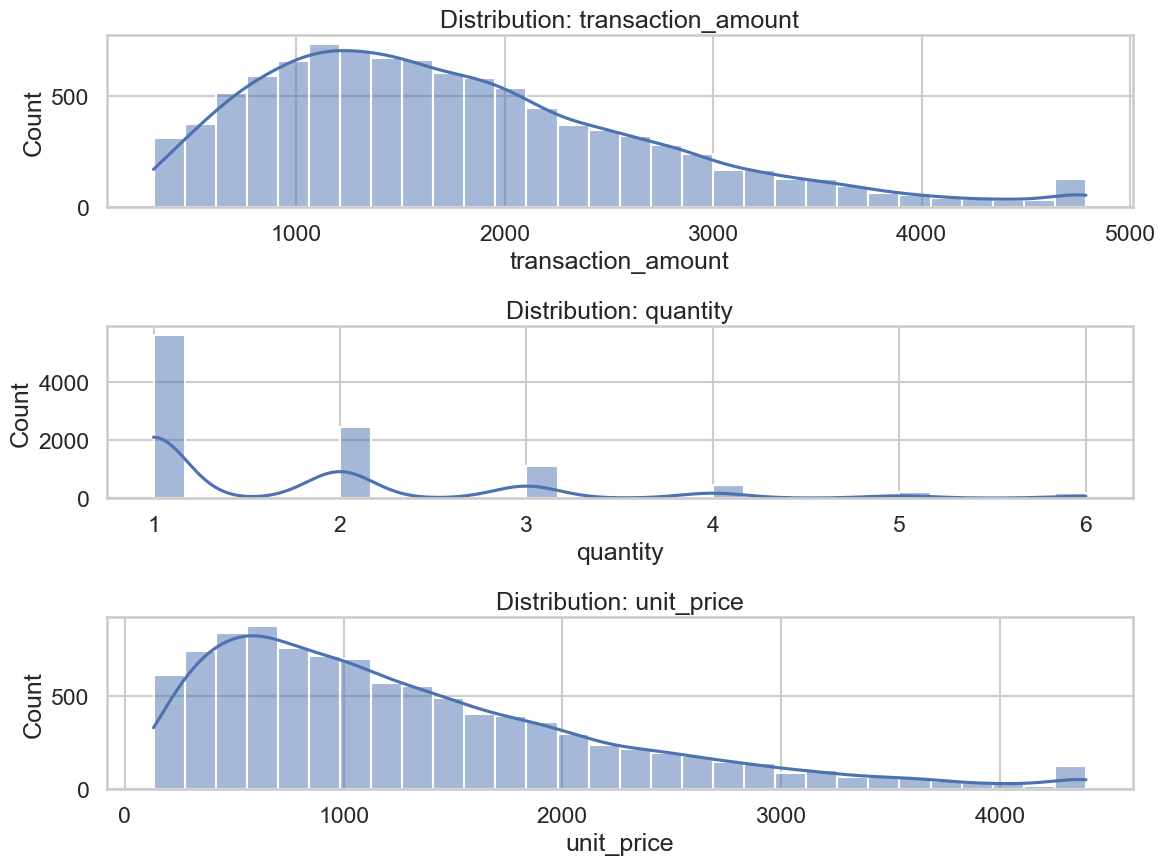

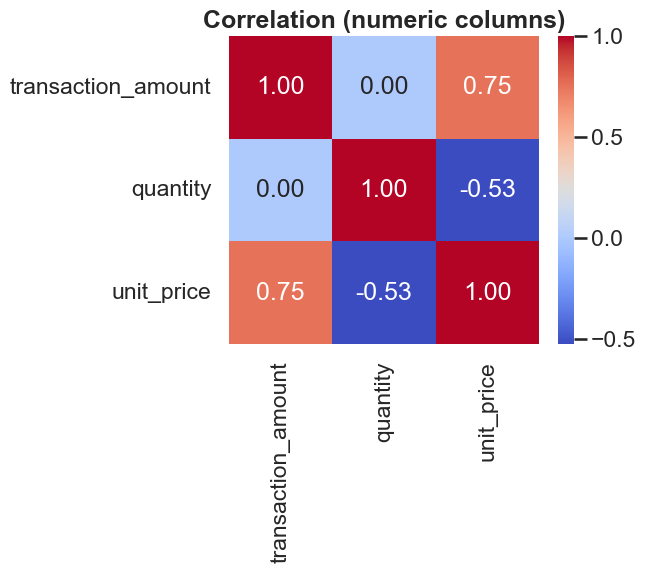

In [6]:
# EDA
num_cols = ["transaction_amount", "quantity", "unit_price"]

plt.figure(figsize=(12, 3*len(num_cols)))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution: {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation (numeric columns)", fontweight="bold")
plt.show()


In [7]:
# RFM Feature Engineering
# Require columns: customer_id, transaction_id, transaction_date, transaction_amount
for required in ["customer_id", "transaction_id", "transaction_date", "transaction_amount"]:
    if required not in df.columns:
        raise KeyError(f"Required column '{required}' not found in dataset.")

snapshot_date = df["transaction_date"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("customer_id").agg(
        Recency=("transaction_date", lambda x: (snapshot_date - x.max()).days),
        Frequency=("transaction_id", "count"),
        Monetary=("transaction_amount", "sum"),
    )
    .reset_index()
)

print("\n>>> RFM head:")
display(rfm.head())
print(">>> RFM shape:", rfm.shape)

# Log transform (reduces skew)
RFM_COLUMNS = ["Recency", "Frequency", "Monetary"]
rfm_log = rfm.copy()
for col in RFM_COLUMNS:
    # add small epsilon inside log1p is fine; log1p handles zeros
    rfm_log[col] = np.log1p(rfm_log[col])

# Standardize for clustering
scaler = StandardScaler()
X = scaler.fit_transform(rfm_log[RFM_COLUMNS])


>>> RFM head:


,customer_id,Recency,Frequency,Monetary
0,C00001,38,11,21577.2700
1,C00002,38,12,21901.2600
2,C00003,38,18,38746.2366
3,C00004,38,12,18411.1608
4,C00005,38,17,34349.0700


>>> RFM shape: (1600, 4)


In [8]:
# KMeans
inertias, silhouettes = {}, {}
for k in range(3, 7):
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(X)
    inertias[k] = km.inertia_
    silhouettes[k] = silhouette_score(X, labels)

best_k = max(silhouettes, key=silhouettes.get)
best_score = silhouettes[best_k]
print(f"\n>>> Best k by silhouette: {best_k} (silhouette = {best_score:.3f})")

# Final model
kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
rfm["cluster"] = kmeans.fit_predict(X)
rfm["silhouette_score"] = best_score

# Check silhouette requirement
silhouette_threshold = 0.5 * (1 - 0.10)
print(f">>> Silhouette threshold (0.5 ±10%) lower bound = {silhouette_threshold:.3f}")


>>> Best k by silhouette: 3 (silhouette = 0.486)
>>> Silhouette threshold (0.5 ±10%) lower bound = 0.450


In [9]:
# Cluster Personas
persona_mean = rfm.groupby("cluster")[RFM_COLUMNS].mean().round(1).sort_values("Monetary", ascending=False)
persona_median = rfm.groupby("cluster")[RFM_COLUMNS].median().round(1)

print("\n>>> Cluster summary (mean RFM):")
display(persona_mean)
print("\n>>> Cluster summary (median RFM):")
display(persona_median)


>>> Cluster summary (mean RFM):


,Recency,Frequency,Monetary
cluster,,,
1,42.8,8.2,14891.9
2,817.0,4.2,7375.7
0,39.2,4.3,7160.7



>>> Cluster summary (median RFM):


,Recency,Frequency,Monetary
cluster,,,
0,38.0,4.0,7289.5
1,38.0,8.0,13898.5
2,694.0,4.0,6715.4


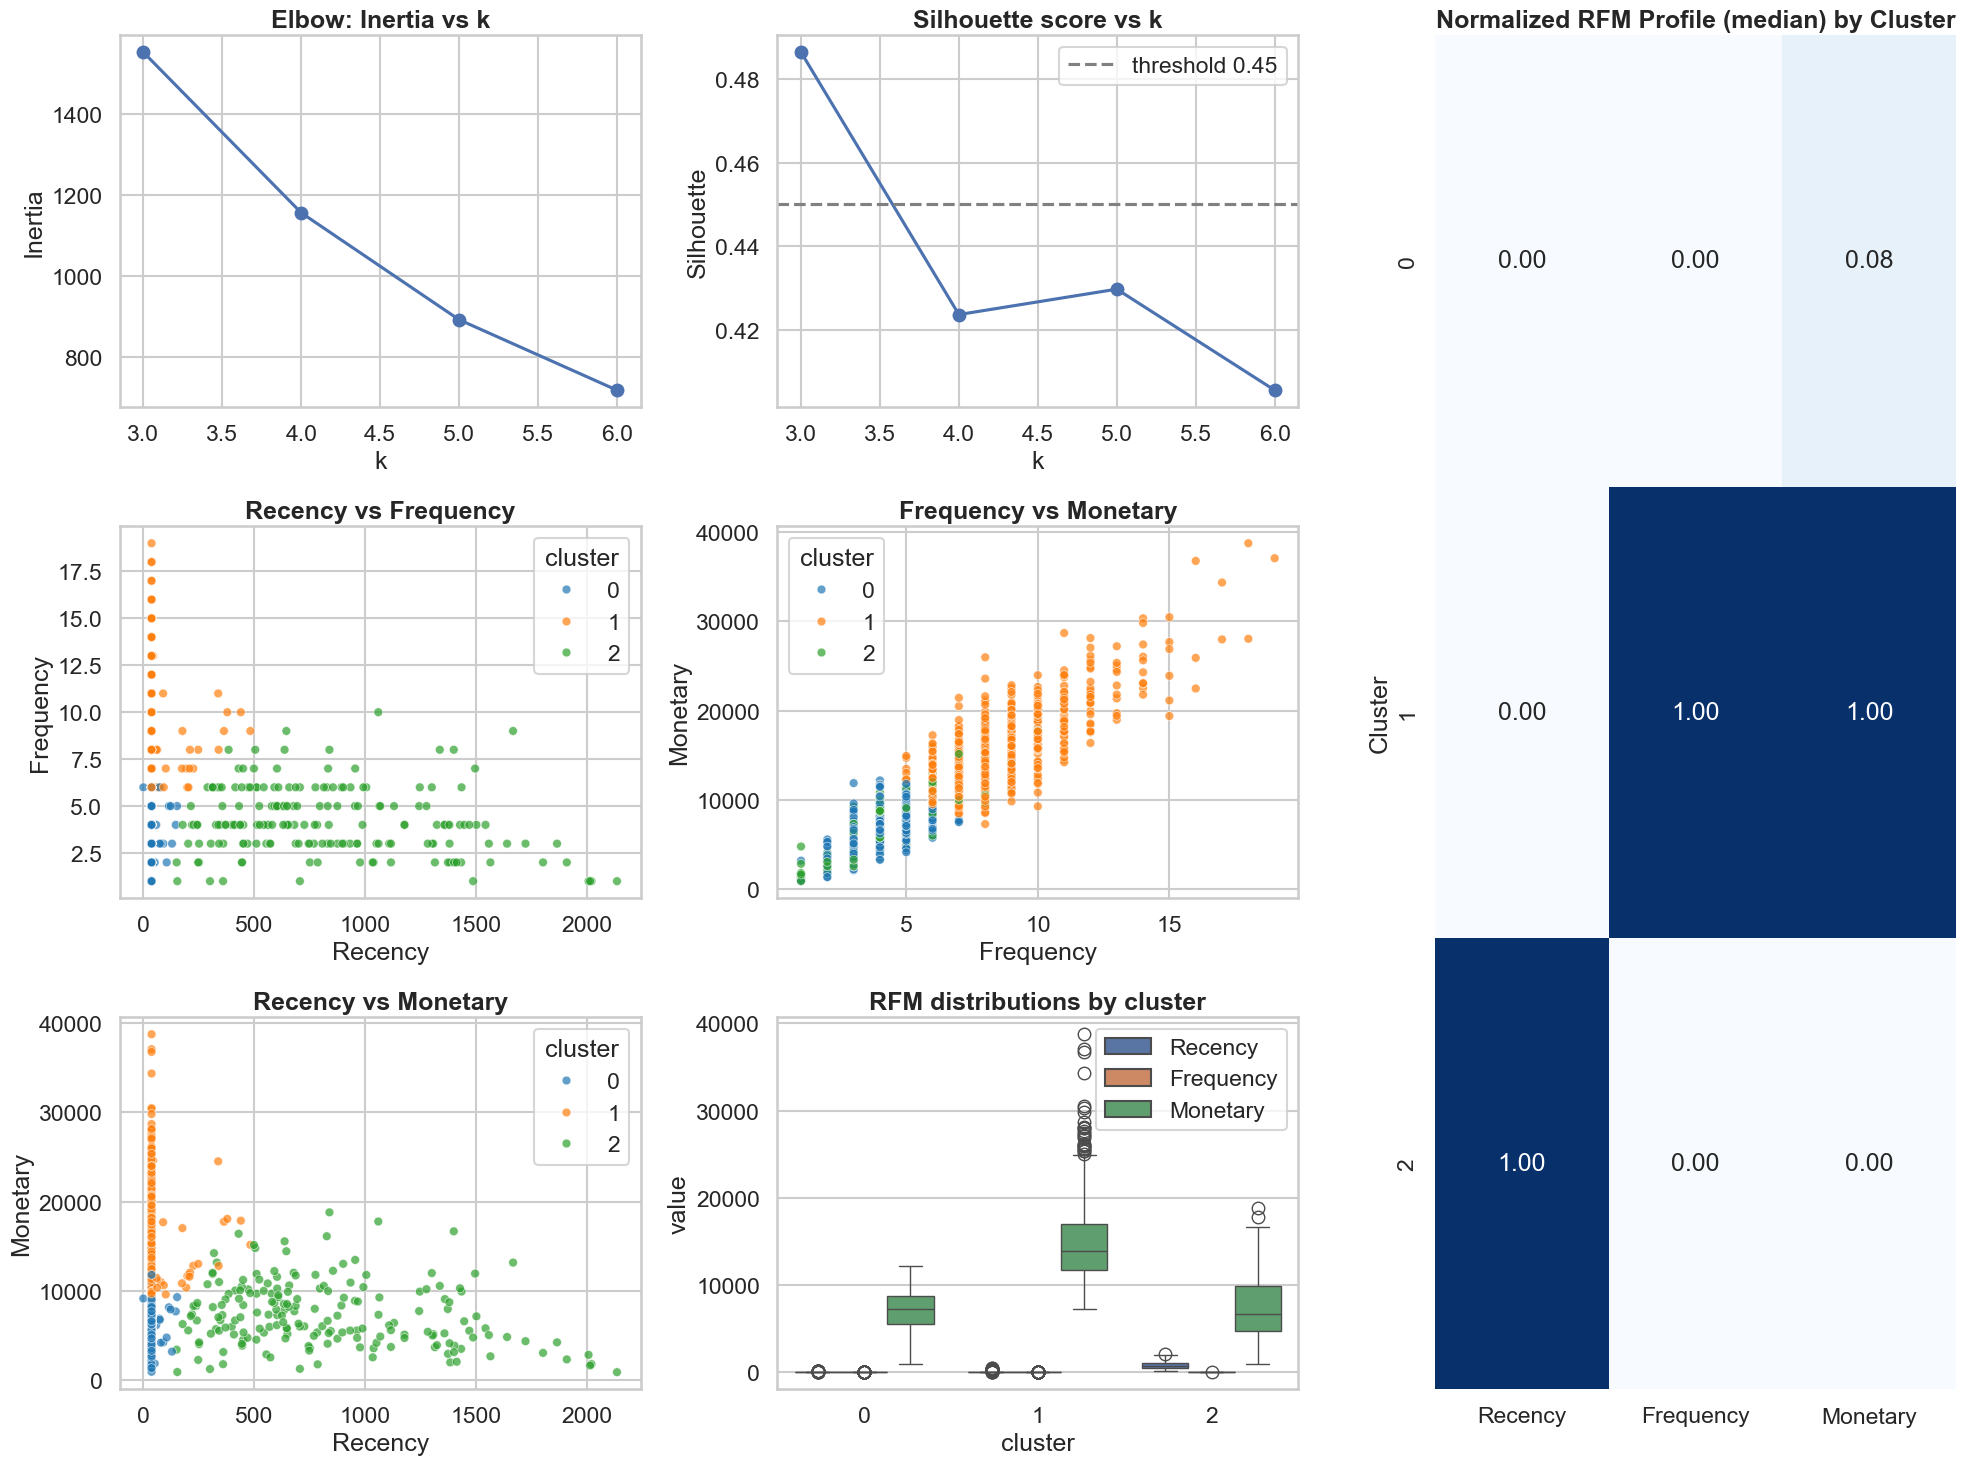

In [10]:
# Dashboard 

fig = plt.figure(figsize=(20,15))

# 1) Elbow & Silhouette summary
ax1 = plt.subplot2grid((3,3), (0,0))
ax1.plot(list(inertias.keys()), list(inertias.values()), marker="o")
ax1.set_title("Elbow: Inertia vs k", fontweight="bold")
ax1.set_xlabel("k")
ax1.set_ylabel("Inertia")

ax2 = plt.subplot2grid((3,3), (0,1))
ax2.plot(list(silhouettes.keys()), list(silhouettes.values()), marker="o")
ax2.axhline(y=silhouette_threshold, color="gray", linestyle="--", label=f"threshold {silhouette_threshold:.2f}")
ax2.set_title("Silhouette score vs k", fontweight="bold")
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette")
ax2.legend()

# 2) RFM scatter plots colored by cluster
ax3 = plt.subplot2grid((3,3), (1,0))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="cluster", palette="tab10", alpha=0.7, s=40, ax=ax3)
ax3.set_title("Recency vs Frequency", fontweight="bold")

ax4 = plt.subplot2grid((3,3), (1,1))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="cluster", palette="tab10", alpha=0.7, s=40, ax=ax4)
ax4.set_title("Frequency vs Monetary", fontweight="bold")

ax5 = plt.subplot2grid((3,3), (2,0))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="cluster", palette="tab10", alpha=0.7, s=40, ax=ax5)
ax5.set_title("Recency vs Monetary", fontweight="bold")

ax6 = plt.subplot2grid((3,3), (2,1))
sns.boxplot(
    data=rfm.melt(id_vars=["cluster"], value_vars=RFM_COLUMNS, var_name="metric", value_name="value"),
    x="cluster", y="value", hue="metric", ax=ax6
)
ax6.set_title("RFM distributions by cluster", fontweight="bold")
ax6.legend(loc="upper right")

# 3) Normalized cluster profile heatmap
ax7 = plt.subplot2grid((3,3), (0,2), rowspan=3)
profile = rfm.groupby("cluster")[RFM_COLUMNS].median()
profile_norm = (profile - profile.min()) / (profile.max() - profile.min())
sns.heatmap(profile_norm, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=ax7)
ax7.set_title("Normalized RFM Profile (median) by Cluster", fontweight="bold")
ax7.set_ylabel("Cluster")

# Layout Adjustments
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.tight_layout()

plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/dashboard.png", dpi=300, bbox_inches="tight")
plt.show()

In [34]:
# --- Slide 3a: Elbow Method ---
plt.figure(figsize=(6,4))
plt.plot(list(inertias.keys()), list(inertias.values()), marker="o")
plt.title("Elbow Method (Best k=3)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide3a_elbow.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Slide 3b: Silhouette Score ---
plt.figure(figsize=(6,4))
plt.plot(list(silhouettes.keys()), list(silhouettes.values()), marker="o", color="green")
plt.axhline(y=silhouette_threshold, color="gray", linestyle="--", label=f"threshold {silhouette_threshold:.2f}")
plt.title("Silhouette Scores (k=3 ≈ 0.48)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.legend()
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide3b_silhouette.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Slide 4a: Recency vs Frequency ---
plt.figure(figsize=(6,4))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="cluster", palette="tab10", alpha=0.7, s=40)
plt.title("Recency vs Frequency by Cluster")
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide4a_recency_frequency.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Slide 4b: Frequency vs Monetary ---
plt.figure(figsize=(6,4))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="cluster", palette="tab10", alpha=0.7, s=40)
plt.title("Frequency vs Monetary by Cluster")
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide4b_frequency_monetary.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Slide 4c: Recency vs Monetary ---
plt.figure(figsize=(6,4))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="cluster", palette="tab10", alpha=0.7, s=40)
plt.title("Recency vs Monetary by Cluster")
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide4c_recency_monetary.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Slide 5a: Boxplot of RFM ---
plt.figure(figsize=(6,4))
sns.boxplot(
    data=rfm.melt(id_vars=["cluster"], value_vars=RFM_COLUMNS, var_name="metric", value_name="value"),
    x="cluster", y="value", hue="metric"
)
plt.title("RFM Distributions by Cluster")
plt.legend(loc="upper right")
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide5a_boxplot.png", dpi=300, bbox_inches="tight")
plt.close()

# --- Slide 5b: Heatmap of Cluster Profiles ---
plt.figure(figsize=(6,4))
profile = rfm.groupby("cluster")[RFM_COLUMNS].median()
profile_norm = (profile - profile.min()) / (profile.max() - profile.min())
sns.heatmap(profile_norm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Normalized RFM Profile (median) by Cluster")
plt.ylabel("Cluster")
plt.savefig("C:/Users/LENOVO/OneDrive/Desktop/slide5b_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()
